# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

сalls — количество звонков,
minutes — суммарная длительность звонков в минутах,
messages — количество sms-сообщений,
mb_used — израсходованный интернет-трафик в Мб,
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**Задача:**

Построить модель классификации, которая выберет подходящий тариф, на основании данных о поведении клиентов, которые уже перешли на эти тарифы. Метрика: accuracy должна быть наибольшей.

## Откроем и изучим файл

Откроем файл и изучим основные характеристики датасета.

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


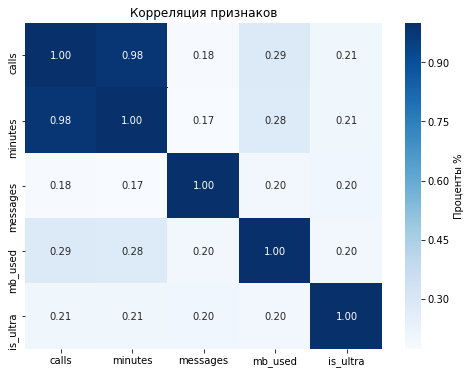

In [4]:
f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(df.corr(), annot=True, fmt=".2f",cbar_kws={'label': 'Проценты %'},cmap="Blues",ax=ax)
ax.set_title('Корреляция признаков');

In [5]:
df.is_ultra.mean()

0.30647168637212197

**Вывод**

наш целевой признак - тариф, тариф Ультра составлят 30.7% выборки. Рспределение неравномерное.

Мы также выявили практические идентичную корреляцию между звонками и минутми, по сему попробуем один признак опустить, пусть это будут минуты.

In [6]:
df = df.drop(['minutes'], axis=1)

## Разобъем данные на выборки

Разделим на обучающую, валидационную и тестовую выборки:

In [12]:
data_train, data_testing = train_test_split(df, test_size = 0.4, random_state = 42)

In [13]:
features_train = data_train.drop(['is_ultra'], axis = 1)
target_train = data_train['is_ultra']

Мы поделили выборку в пропорции 60%/40%. 60 - наша обучающая выборка. 40 - это наши валидационная и тестовая выборки, которые мы разделим ниже.

In [14]:
print('Размеры обучающей выборки:')
print(features_train.shape)
print(target_train.shape)

Размеры обучающей выборки:
(1928, 3)
(1928,)


In [15]:
data_valid, data_test = train_test_split(data_testing, test_size = 0.5, random_state = 42)

In [16]:
features_valid = data_valid.drop(['is_ultra'], axis = 1)
target_valid   = data_valid['is_ultra']
print('Размеры валидационной выборки:')
print(features_valid.shape)
print(target_valid.shape)
print()

features_test = data_test.drop(['is_ultra'], axis = 1)
target_test   = data_test['is_ultra']
print('Размеры тестовой выборки:')
print(features_test.shape)
print(target_test.shape)

Размеры валидационной выборки:
(643, 3)
(643,)

Размеры тестовой выборки:
(643, 3)
(643,)


Разделили выборку на обучающую, валидационную, тестовую части в пропорции: 60%, 20%, 20%.

## Исследуем модели

Нам нужно решить задачу бинарной классификации, так как пользователи выбирают один из двух предложенных тарифов. Для решения этой задачи обратимся к следующим моделям из библиотеки sklearn:

- Логистическая регрессия LogisticRegression
- Дерево решений DecisionTreeClassifier
- Случайный лес RandomForestClassifier

1. **Дерево решений**

In [24]:
models_dict = {}
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
tree_result_list = []

for depth in range(1, 21):
    tree_model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    tree_model.fit(features_train, target_train)
    
    tree_result = tree_model.score(features_valid, target_valid)
    tree_result_list.append(tree_result)

    if tree_result > best_tree_result:
        best_tree_model = tree_model
        best_tree_result = tree_result
        best_tree_depth = depth
        
print('Accuracy лучшей модели в дереве решений:', round(best_tree_result, 3))
print('Достигается при глубине', best_tree_depth)

models_dict['Tree'] = best_tree_result

Accuracy лучшей модели в дереве решений: 0.813
Достигается при глубине 8


2. **Случайный лес**

In [35]:
best_forest_model = None
best_forest_result = 0
best_forest_est = 0
best_forest_depth = 0
f_list = []

for est in range(1, 100):
    forest_result_list = []
    for depth in range (1, 15):
        forest_model = RandomForestClassifier(random_state=123, n_estimators=est, max_depth=depth)
        forest_model.fit(features_train, target_train) 
        forest_result = forest_model.score(features_valid, target_valid)
        forest_result_list.append(forest_result)
        if forest_result > best_forest_result:
            best_forest_model = forest_model
            best_forest_result = forest_result
            best_forest_est = est
            best_forest_depth = depth
print("Accuracy наилучшей модели случайного леса на валидационной выборке:", round(best_forest_result, 3))
print("Количество деревьев:", best_forest_est)
print("Максимальная глубина:", best_forest_depth)

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.824
Количество деревьев: 17
Максимальная глубина: 8


In [36]:
models_dict['R Forest'] = 0.824

3. **Логистическая регрессия**

Выбрали параметр solver='liblinear', так как у нас небольшая выборка данных

In [52]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
accuracy = model.score(features_valid,target_valid)

print('Качество модели LogisticRegression:', accuracy)

Качество модели LogisticRegression: 0.7309486780715396


In [50]:
models_dict['L Regress'] = 0.731

In [51]:
models_dict

{'Tree': 0.8133748055987559, 'R Forest': 0.824, 'L Regress': 0.731}

Изучив результаты наших моделей, можем сказать, что самый лучший результат был показан моделью Случайный лес (0.824) с гиперпараметрами: Количество деревьев: 17, Максимальная глубина: 8

Модель линейной регрессии не прошла пороговое значение в 0.75.

## Проверка модели на тестовой выборке

In [53]:
my_model = RandomForestClassifier(random_state=42, n_estimators=17, max_depth=8)
my_model.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid])) 
my_result = my_model.score(features_test, target_test)
print(f'Результат модели на тестовой выборке: {my_result:.3f}')

Результат модели на тестовой выборке: 0.818


## Проверим модель на адекватность

Проверим модель с помощью классификатора-DummyClassifier, с использованием стратегии - most_frequent, кготорая всегда предсказывает наиболее частую метку в обучающем наборе

In [60]:
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(features_train,target_train)
accuracy_dummy = dummy.score(features_test,target_test)
print('Классификатор "Dummy" :', accuracy_dummy)
print('Качество модели "Случайный лес": ', my_result)

Классификатор "Dummy" : 0.6967340590979783
Качество модели "Случайный лес":  0.8180404354587869


**Вывод**

Мы обучили модели классификации: "решающее дерево", "случайный лес", "логистическая регрессия" для определения подходящего тарифа с целевой точностью выше 0.75.

Мы пробовали различные гиперпараметры и смогли подобрать оптимальные: лучшие показатели были зафиксированы для модели Случайный лес при параметрах: количество деревьев - 17 и глубина - 8. Модель Решающее дерево показало немногим более худший результат. Логистическая регрессия не прошла пороговый уровень в 0.75.

Наша модель "случайного леса" дает 81,8%-ю точность предсказания подходящего тарифа сотовой связи.